In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
batch_size = 256
epochs = 50
lr = 1e-4
data_set_root = "../../datasets"

In [3]:
transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

In [4]:
train_data = datasets.CIFAR10(data_set_root,
                              train=True,
                              download=True,
                              transform=transform)

test_data = datasets.CIFAR10(data_set_root,
                             train=False,
                             download=True,
                             transform=test_transform)

validation_split = 0.9

n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.Generator().manual_seed(42))

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


In [5]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [6]:
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader = dataloader.DataLoader(test_data, batch_size=batch_size)

In [37]:
class_names = train_data.dataset.classes

In [17]:
class AttentionCNN(nn.Module):
  def __init__(self, in_channels, out_channels=10):
    super().__init__()

    self.conv_1 = nn.Conv2d(in_channels=in_channels,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1,
                            padding_mode='reflect')

    self.layer_norm = nn.LayerNorm(64)
    self.multi_head_attention = nn.MultiheadAttention(embed_dim=64,
                                                      num_heads=1,
                                                      batch_first=True)
    self.scale = nn.Parameter(torch.zeros(1))

    self.conv_2 = nn.Conv2d(in_channels=64,
                            out_channels=64,
                            kernel_size=3,
                            stride=2,
                            padding=1)
    self.batch_norm_1 = nn.BatchNorm2d(64)

    self.conv_3 = nn.Conv2d(in_channels=64,
                            out_channels=128,
                            kernel_size=3,
                            stride=2,
                            padding=1)
    self.batch_norm_2 = nn.BatchNorm2d(128)

    self.conv_4 = nn.Conv2d(in_channels=128,
                            out_channels=128,
                            kernel_size=3,
                            stride=2,
                            padding=1)
    self.batch_norm_3 = nn.BatchNorm2d(128)

    self.dropout = nn.Dropout(p=0.5)
    self.fc_out = nn.Linear(in_features=(128 * 4 * 4), out_features=out_channels)

  def use_attention(self, x):
    batch_size, c, h, w = x.shape
    x_att = x.reshape(batch_size, c, h * w).permute(0, 2, 1) # (batch_size, h * w, c)

    x_att = self.layer_norm(x_att)
    att_out, att_map  = self.multi_head_attention(x_att, x_att, x_att)
    return att_out.permute(0, 2, 1).reshape(batch_size, c, h, w), att_map # (batch_size, c, h, w)

  def forward(self, x):
    # x shape: (batch_size, c, h, w)
    x = self.conv_1(x) # (batch_size, c, h, w) -> (batch_size, 64, h, w)

    # Self-Attention and Residual Connection
    x = F.relu(self.scale * self.use_attention(x)[0] + x) # (batch_size, 64, h, w)

    x = F.relu(self.batch_norm_1(self.conv_2(x))) # (batch_size, 64, h, w) -> (batch_size, 64, h / 2, w / 2)
    x = F.relu(self.batch_norm_2(self.conv_3(x))) # (batch_size, 64, h / 2, w / 2) -> (batch_size, 128, h / 4, w / 4)
    x = F.relu(self.batch_norm_3(self.conv_4(x))) # (batch_size, 128, h / 4, w / 4) -> (batch_size, 128, h / 8, w / 8)

    # Flatten the output
    x = self.dropout(x.reshape(x.shape[0], -1)) # (batch_size, 128, 4, 4) -> (batch_size, 128 * 4 * 4)

    return self.fc_out(x) # (batch_size, 128 * 4 * 4) -> (batch_size, out_channels)

In [18]:
test_images, test_labels = next(iter(test_loader))

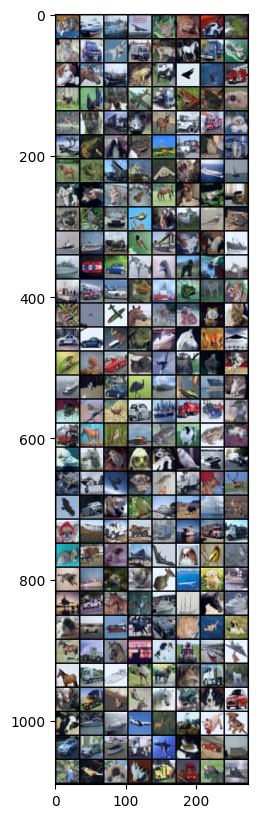

In [19]:
plt.figure(figsize=(20, 10))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [20]:
model = AttentionCNN(in_channels=test_images.shape[1], out_channels=10).to(device)

In [21]:
num_model_params = 0
for param in model.parameters():
  num_model_params += param.flatten().shape[0]

print(f"This Model Has ${num_model_params} parameters")

This Model Has $298059 parameters


In [22]:
out = model(test_images.to(device))
out.shape

torch.Size([256, 10])

In [23]:
optimizer = optim.Adam(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [24]:
def train(model, optimizer, loader, device, loss_fn):
  model.train()

  for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
    x, y = x.to(device), y.to(device)

    output = model(x)

    loss = loss_fn(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return model, loss.item()

In [25]:
def evaluate(model, device, loader):
  epoch_acc = 0
  model.eval()

  with torch.inference_mode():
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
      x, y = x.to(device), y.to(device)

      output = model(x)

      epoch_acc += (output.argmax(1) == y).sum().item()

  return epoch_acc / len(loader.dataset)

In [27]:
train_loss = 0

pbar = trange(0, epochs, leave=False, desc="Epoch")

for epoch in pbar:
  model, train_loss = train(model=model,
                            optimizer=optimizer,
                            loader=train_loader,
                            device=device,
                            loss_fn=loss_fn)

  pbar.set_postfix_str(f"Train loss: {train_loss}")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

In [31]:
train_acc = evaluate(model=model, device=device, loader=train_loader)
valid_acc = evaluate(model=model, device=device, loader=valid_loader)

print(f"Train Accuracy: {train_acc * 100} | Validation Accuracy: {valid_acc * 100}")

Evaluating:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Accuracy: 77.21555555555555 | Validation Accuracy: 69.08


Predicted Values
 ['cat', 'automobile', 'ship', 'ship', 'frog', 'frog', 'automobile', 'frog']
True Values
 ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']


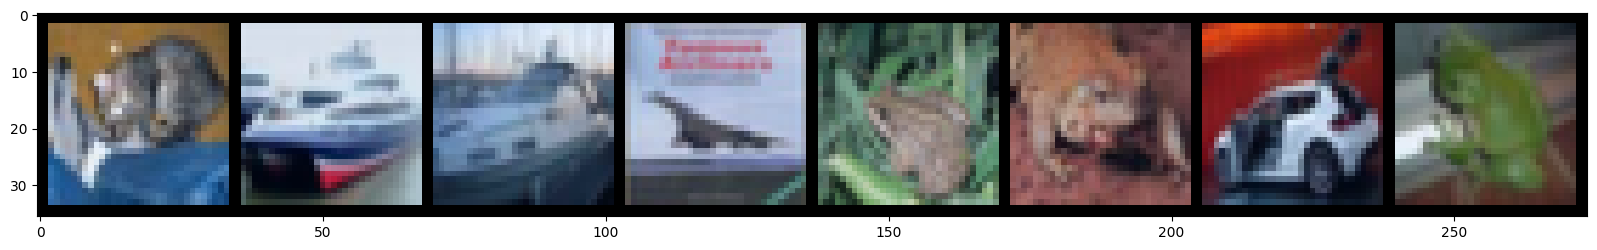

In [43]:
with torch.inference_mode():
  pred = model(test_images[:8].to(device)).argmax(-1)

plt.figure(figsize=(20, 10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", [class_names[x] for x in list(pred.cpu().numpy())])
print("True Values\n", [class_names[x] for x in list(test_labels[:8].numpy())])

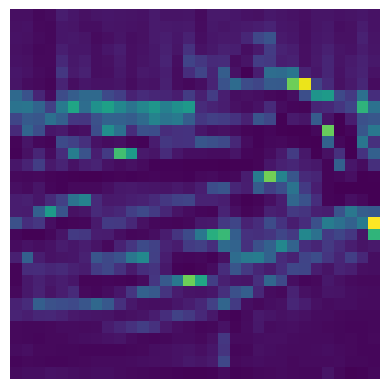

In [57]:
idx = 2

with torch.inference_mode():
  x = model.conv_1(test_images[idx].unsqueeze(dim=0).to(device))
  _, att_map = model.use_attention(x)

img_idx = 0
x_dim = 5
y_dim = 25

assert x_dim < test_images.shape[3], "x_dim must be less than " + str(test_images.shape[3] - 1)
assert y_dim < test_images.shape[2], "y_dim must be less than " + str(test_images.shape[2] - 1)

plt.imshow(att_map[img_idx, x_dim * y_dim].reshape(32, 32).cpu().numpy(), cmap='viridis')
plt.axis(False)

plt.show()